# use bounding poly returned by GCV to match words in the same line into one word

In [250]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [527]:
from src.config import work_dir_path
import re
from src.ocr_base.text_processing.normlise_text import Normaliser
from src.ocr_insurance_card.text_processing.regex import PostprocessRegex as PR
from src.ocr_base.accuracy.metric import Metric
import pickle  # library to save python dictionaries into a file that can be loaded again
import pprint
from src.ocr_base.image_processing.bounding_poly import BoundingPoly as BP
import numpy as np

# ## load data
from src.ocr_insurance_card.pipeline.load_data import *

In [3]:
raw_text = gcv_text_dict["01"]
print("raw_text:", raw_text)

reformed_text = PR.gcv_text_reform(text=raw_text)
print("reformed_text", reformed_text)

# keywords = hint_dict["Dependent"]["keyword"]
# data_type = hint_dict["Dependent"]["type"]
#
# print("keywords:", keywords)
# print("data_type:", data_type)
#
# print(PR.data_type_to_regex(data_type=data_type))
# print(PR.regex_gen(keywords=keywords, output_type=data_type))
#
# pred = PR.extract_info_regex(text=reformed_text)
# pprint.pprint(pred)


# ### run for multiple images/keys
# pred_multi = PR.extract_info_multi(input_dict=gcv_text_dict)
# # pprint.pprint(pred_multi)
#
#
#
# ### compute accuracy
# accuracy = Metric.metric(predict=pred_multi, target=label_dict)
# pprint.pprint(accuracy, depth=3, width=100)

raw_text: 健康保険本人(被保険者) 昭和49年 12月29日 交付
被保険者証
記号 2359 番号 23387
氏名 小嶋 正雄
性別 男
生年月日 昭和49年 12月29日
認定年月日 昭和49年12月29日
に
保険者所在地
保険者番号
保険者名称
京都府京都市左京区下鴨芝本町1-13-16
06260012 8077-891-4901
イシバシ健康保険組合

reformed_text  健康保険本人(被保険者) 昭和49年 12月29日 交付 被保険者証 記号 2359 番号 23387 氏名 小嶋 正雄 性別 男 生年月日 昭和49年 12月29日 認定年月日 昭和49年12月29日 に 保険者所在地 保険者番号 保険者名称 京都府京都市左京区下鴨芝本町1-13-16 06260012 8077-891-4901 イシバシ健康保険組合


In [4]:
texts_sep = gcv_res_dict["01"]["full_text"][1:]
bp_raw = gcv_res_dict["01"]["bouding_poly"][1:]
for idx in range(len(texts)):
    print(texts_sep[idx])
    print(bp_raw[idx])

NameError: name 'texts' is not defined

In [36]:
# convert bounding poly in string form into np.array 
bp_array = []
for value in bp_raw:
    tmp_array = np.array(eval(value), dtype = "float32")
    bp_array.append(tmp_array)
bp_array[0]

array([[ 61.,  40.],
       [382.,  44.],
       [381.,  92.],
       [ 60.,  88.]], dtype=float32)

By default, the bounding poly returned by GCV is in the format: `[(tl),(tr),(br),(bl)]`

### check overlap

In [191]:
def overlap(two_bp):
    (tl1, tr1, br1, bl1) = two_bp[0]
    (tl2, tr2, br2, bl2) = two_bp[1]
    (ml1, mr1) = ((tl1+bl1)/2, (tr1+br1)/2)
    (ml2, mr2) = ((tl2+bl2)/2, (tr2+br2)/2)
    # compute area of the rectangular formed 
    # by the 4 points that are the co-ordinators of the given 2 lines
    fpts_bottom = np.array([br1, bl1, br2, bl2]) 
    fpts_top = np.array([tl1, tr1, tl2, tr2])
    fpts_middel = np.array([ml1, mr1, ml1, mr2])
    area = BP.rect_area(fpts_bottom)
    # concat the 2 texts if the area is very small or close to 0
    error = 0
#     if (BP.rect_area(fpts_bottom)< error or BP.rect_area(fpts_top)< error or BP.rect_area(fpts_middel)< error) :
#     if (BP.rect_area(fpts_bottom)< error or BP.rect_area(fpts_top)< error):
    if (BP.rect_area(fpts_bottom) == error):
        print(fpts_bottom)
        return True
    else:
        return False

In [192]:
def match_inline_texts(two_texts, two_bp):
    """
    """
    text1 = two_texts[0]
    text2 = two_texts[1]
    (tl1, tr1, br1, bl1) = two_bp[0]
    (tl2, tr2, br2, bl2) = two_bp[1]
    # form joint text
    joint_text = text1 + " " + text2
    # form new bp
    joint_tl = [min(tl1[0], tl2[0]), min(tl1[1], tl2[1])]
    joint_br = [max(tl1[0], tl2[0]), max(tl1[1], tl2[1])]
    joint_tr = [max(tl1[0], tl2[0]), min(tl1[1], tl2[1])]
    joint_bl = [min(tl1[0], tl2[0]), max(tl1[1], tl2[1])]
    joint_bp = np.array([joint_tl, joint_tr, joint_br, joint_bl])
    return (joint_text, joint_bp)

In [193]:
short_texts = gcv_res_dict["01"]["full_text"][1:]
# short_texts

In [194]:
# match the texts and find the joint bp
def concat_text(texts, bps):
    for idx in range(len(texts)-1):
        two_texts = texts[:2]
        two_bp = bps[:2]
        if overlap(two_bp):
            (joint_text, joint_bp) = match_inline_texts(two_texts, two_bp)
            # remove the 2 texts from the element_texts vectors
            del texts[:2]
            del bps[:2]
            # add the joint_text and joint_bp to element_bp vectors
            texts.insert(0, joint_text)
            bps.insert(0, joint_bp)
#         print(len(texts))
#     print(texts)
    return (texts, bps)
concat_text(short_texts, short_texts_bp)

[[381.  92.]
 [ 60.  88.]
 [399.  92.]
 [386.  92.]]
[[387.  45.]
 [ 61.  45.]
 [502.  93.]
 [400.  92.]]
[[401.  45.]
 [ 61.  45.]
 [523.  93.]
 [510.  93.]]
[[511.  46.]
 [ 61.  46.]
 [644.  96.]
 [528.  94.]]
[[529.  46.]
 [ 61.  46.]
 [836.  98.]
 [694.  96.]]
[[695.  49.]
 [ 61.  49.]
 [932. 100.]
 [880.  99.]]


(['健康保険本人 ( 被保険者 ) 昭和49年 12月29日 交付',
  '被保険者証',
  '記号',
  '2359',
  '番号',
  '23387',
  '氏名',
  '小嶋',
  '正雄',
  '性別',
  '男',
  '生年月日',
  '昭和49年',
  '12月29日',
  '認定年月日',
  '昭和49年12月29日',
  'に',
  '保険者所在地',
  '保険者番号',
  '保険者名称',
  '京都府京都市左京区下鴨芝本町1',
  '-',
  '13',
  '-',
  '16',
  '06260012',
  '8077',
  '-',
  '891',
  '-',
  '4901',
  'イシバシ健康保険組合'],
 [array([[ 61.,  40.],
         [881.,  40.],
         [881.,  51.],
         [ 61.,  51.]], dtype=float32), array([[ 65.,  92.],
         [223.,  92.],
         [223., 132.],
         [ 65., 132.]], dtype=float32), array([[295., 150.],
         [326., 150.],
         [326., 208.],
         [295., 208.]], dtype=float32), array([[360., 150.],
         [476., 150.],
         [476., 208.],
         [360., 208.]], dtype=float32), array([[517., 150.],
         [559., 150.],
         [559., 208.],
         [517., 208.]], dtype=float32), array([[582., 150.],
         [709., 150.],
         [709., 208.],
         [582., 208.]], dtype=float32), array

In [195]:
(concat_match_texts , concat_match_bps) = concat_text(match_texts, match_bps)
concat_match_texts

[['昭和49年 12月29日'],
 ['被保険者証'],
 ['記号 2359 番号 23387'],
 ['氏名 小嶋 正雄'],
 ['性別 男'],
 ['生年月日 昭和49年 12月29日'],
 ['昭和49年 12月29日 認定年月日 昭和49年12月29日'],
 ['に'],
 ['保険者所在地'],
 ['番号 保険者番号'],
 ['保険者名称'],
 ['京都府京都市左京区下鴨芝本町1 - 13 - 16 - -'],
 ['- - 06260012 8077 - 891 - 4901'],
 ['イシバシ健康保険組合']]

In [196]:
# find the bp of each text in the longest string from bp of the seperate text
long_text = gcv_text_dict["01"]
long_text

'健康保険本人(被保険者) 昭和49年 12月29日 交付\n被保険者証\n記号 2359 番号 23387\n氏名 小嶋 正雄\n性別 男\n生年月日 昭和49年 12月29日\n認定年月日 昭和49年12月29日\nに\n保険者所在地\n保険者番号\n保険者名称\n京都府京都市左京区下鴨芝本町1-13-16\n06260012 8077-891-4901\nイシバシ健康保険組合\n'

In [197]:
short_texts_bp = gcv_res_dict["01"]["bouding_poly"][1:]
# convert bounding poly in string form into np.array 
bp_array = []
for value in short_texts_bp:
    tmp_array = np.array(eval(value), dtype = "float32")
    bp_array.append(tmp_array)
short_texts_bp = bp_array

In [198]:
sep_texts = long_text.split("\n")
print(len(sep_texts))
sep_texts
# test_text = sep_texts[0]
# test_text

15


['健康保険本人(被保険者) 昭和49年 12月29日 交付',
 '被保険者証',
 '記号 2359 番号 23387',
 '氏名 小嶋 正雄',
 '性別 男',
 '生年月日 昭和49年 12月29日',
 '認定年月日 昭和49年12月29日',
 'に',
 '保険者所在地',
 '保険者番号',
 '保険者名称',
 '京都府京都市左京区下鴨芝本町1-13-16',
 '06260012 8077-891-4901',
 'イシバシ健康保険組合',
 '']

In [199]:
element_texts = []
element_bp = []
for idx in range(len(short_texts)):
    text = short_texts[idx]
    if text in test_text:
        element_texts.append(text)
        element_bp.append(short_texts_bp[idx])
print(element_texts)
len(element_texts)
element_texts[:2]

['昭和49年', '12月29日']


['昭和49年', '12月29日']

In [200]:
# match the texts and find the joint bp
for idx in range(len(element_texts)-1):
    two_texts = element_texts[:2]
    two_bp = element_bp[:2]
    (joint_text, joint_bp) = match_inline_texts(two_texts, two_bp)
    # remove the 2 texts from the element_texts vectors
    del element_texts[:2]
    del element_bp[:2]
    # add the joint_text and joint_bp to element_bp vectors
    element_texts.insert(0, joint_text)
    element_bp.insert(0, joint_bp)
    print(len(element_texts))
print(element_texts)
element_bp

1
['昭和49年 12月29日']


[array([[290., 221.],
        [368., 221.],
        [368., 221.],
        [290., 221.]], dtype=float32)]

In [324]:
match_texts = []
match_bp = []
for value in sep_texts:
    test_text = value
    # find all the element strings that are part of the text
    element_texts = []
    element_bp = []
    for idx in range(len(short_texts)):
        text = short_texts[idx]
        if text in test_text:
            element_texts.append(text)
            element_bp.append(short_texts_bp[idx])
            
    # match the texts and find the joint bp
    for idx in range(len(element_texts)-1):
        two_texts = element_texts[:2]
        two_bp = element_bp[:2]
        (joint_text, joint_bp) = match_inline_texts(two_texts, two_bp)
        # remove the 2 texts from the element_texts vectors
        del element_texts[:2]
        del element_bp[:2]
        # add the joint_text and joint_bp to element_bp vectors
        element_texts.insert(0, joint_text)
        element_bp.insert(0, joint_bp)
    
    if len(element_texts)>0:
        match_texts.append(element_texts)
        match_bp.append(element_bp)

In [325]:
print(len(match_texts))
match_texts

14


[['健康保険本人 ( 被保険者 ) 昭和49年 12月29日 交付 昭和49年 12月29日'],
 ['被保険者 被保険者証'],
 ['記号 2359 番号 23387'],
 ['氏名 小嶋 正雄'],
 ['性別 男'],
 ['昭和49年 12月29日 生年月日 昭和49年 12月29日'],
 ['昭和49年 12月29日 昭和49年 12月29日 認定年月日 昭和49年12月29日'],
 ['に'],
 ['保険者所在地'],
 ['番号 保険者番号'],
 ['保険者名称'],
 ['京都府京都市左京区下鴨芝本町1 - 13 - 16 - -'],
 ['- - 06260012 8077 - 891 - 4901'],
 ['イシバシ健康保険組合']]

In [326]:
print(len(match_bp))
match_bp

14


[[array([[ 61.,  40.],
         [617.,  40.],
         [617., 319.],
         [ 61., 319.]], dtype=float32)], [array([[ 65.,  45.],
         [401.,  45.],
         [401.,  92.],
         [ 65.,  92.]], dtype=float32)], [array([[295., 150.],
         [582., 150.],
         [582., 150.],
         [295., 150.]], dtype=float32)], [array([[290., 221.],
         [510., 221.],
         [510., 221.],
         [290., 221.]], dtype=float32)], [array([[290., 276.],
         [370., 276.],
         [370., 276.],
         [290., 276.]], dtype=float32)], [array([[281.,  46.],
         [617.,  46.],
         [617., 319.],
         [281., 319.]], dtype=float32)], [array([[293.,  46.],
         [451.,  46.],
         [451., 364.],
         [293., 364.]], dtype=float32)], [array([[157., 353.],
         [200., 353.],
         [200., 365.],
         [157., 365.]], dtype=float32)], [array([[ 62., 452.],
         [229., 452.],
         [229., 484.],
         [ 62., 484.]], dtype=float32)], [array([[ 60., 150

In [314]:
match_bps = []
for idx in range(len(match_bp)):
    print(idx)
    match_bps.append(match_bp[idx][0])
match_bps

0
1
2
3
4
5
6
7
8
9
10
11
12
13


[array([[ 61.,  40.],
        [617.,  40.],
        [617., 319.],
        [ 61., 319.]], dtype=float32), array([[ 65.,  45.],
        [401.,  45.],
        [401.,  92.],
        [ 65.,  92.]], dtype=float32), array([[295., 150.],
        [582., 150.],
        [582., 150.],
        [295., 150.]], dtype=float32), array([[290., 221.],
        [510., 221.],
        [510., 221.],
        [290., 221.]], dtype=float32), array([[290., 276.],
        [370., 276.],
        [370., 276.],
        [290., 276.]], dtype=float32), array([[281.,  46.],
        [617.,  46.],
        [617., 319.],
        [281., 319.]], dtype=float32), array([[293.,  46.],
        [451.,  46.],
        [451., 364.],
        [293., 364.]], dtype=float32), array([[157., 353.],
        [200., 353.],
        [200., 365.],
        [157., 365.]], dtype=float32), array([[ 62., 452.],
        [229., 452.],
        [229., 484.],
        [ 62., 484.]], dtype=float32), array([[ 60., 150.],
        [517., 150.],
        [517., 502.]

In [205]:
len(short_texts_bp)

38

In [206]:
# matching text by comparing the bouding poly position
text_line_match = []

for idx in range(len(texts_sep)-1):
# for idx in range(2):
    text1 = texts_sep[idx]
    tmp_bp1 = bp_array[idx]
    print(text1)
    (tl1, tr1, br1, bl1) = tmp_bp1
    print(tl1, tr1, br1, bl1)
    # we will compare the 3 lines:
    # 1.bottom line, 
    # 2.top line
    # 3.middle line: the line between the bottom and top line of the rectangular
    # if any of the 3 lines overlap, concat the words contains in those bounding poly
    text2 = texts_sep[idx+1]
    tmp_bp2 = bp_array[idx+1]
    print(text2)
    (tl2, tr2, br2, bl2) = tmp_bp2
    print(tl2, tr2, br2, bl2)
    
    # check if the 2 lines are overlaped by computing the area of the rectangular formed 
    # by the 4 points that are the co-ordinators of the given 2 lines
    fpts = np.array([br1, bl1, br2, bl2]) 
    if overlap(fpts):
        two_texts = texts_sep[idx:idx+1]
        two_bp = bp_array[idx:idx+1]
        (joint_text, joint_bp) = match_inline_texts(two_texts, two_bp)
    
#     # first, consider 2 lines formed by (br1, bl1) and (br2, bl2)
#     print(tmp_bp2.shape)
#     print(tmp_bp2[0])
#     fpts = np.array([br1, bl1, br2, bl2]) 
#     print("initial 4pts:", fpts)
#     # re-order the 4 points so that we have a rectangular in the form ([(tl),(tr),(br),(bl)])
#     ordered_fpts = BP.order_points(fpts)
#     print("re-order 4pts:", ordered_fpts)
#     # compute area of the rectangular 
#     area = BP.rect_area(ordered_fpts)
#     print("area=", area)
#     # concat the 2 texts if the area is very small or close to 0
#     if area < 10**(-2):
#         tmp_concat = text1 + " " + text2
#         text_line_match.append(tmp_concat)
    
print(text_line_match)

健康保険本人
[61. 40.] [382.  44.] [381.  92.] [60. 88.]
(
[387.  45.] [400.  45.] [399.  92.] [386.  92.]


ValueError: not enough values to unpack (expected 4, got 2)

In [207]:
short_texts = gcv_res_dict["01"]["full_text"][1:]
short_texts

['健康保険本人',
 '(',
 '被保険者',
 ')',
 '昭和49年',
 '12月29日',
 '交付',
 '被保険者証',
 '記号',
 '2359',
 '番号',
 '23387',
 '氏名',
 '小嶋',
 '正雄',
 '性別',
 '男',
 '生年月日',
 '昭和49年',
 '12月29日',
 '認定年月日',
 '昭和49年12月29日',
 'に',
 '保険者所在地',
 '保険者番号',
 '保険者名称',
 '京都府京都市左京区下鴨芝本町1',
 '-',
 '13',
 '-',
 '16',
 '06260012',
 '8077',
 '-',
 '891',
 '-',
 '4901',
 'イシバシ健康保険組合']

In [208]:
bp_raw = gcv_res_dict["01"]["bouding_poly"][1:]
# convert bounding poly in string form into np.array 
short_texts_bp = []
for value in bp_raw:
    tmp_array = np.array(eval(value), dtype = "float32")
    short_texts_bp.append(tmp_array)
short_texts_bp

[array([[ 61.,  40.],
        [382.,  44.],
        [381.,  92.],
        [ 60.,  88.]], dtype=float32), array([[387.,  45.],
        [400.,  45.],
        [399.,  92.],
        [386.,  92.]], dtype=float32), array([[401.,  45.],
        [503.,  46.],
        [502.,  93.],
        [400.,  92.]], dtype=float32), array([[511.,  46.],
        [524.,  46.],
        [523.,  93.],
        [510.,  93.]], dtype=float32), array([[529.,  46.],
        [645.,  48.],
        [644.,  96.],
        [528.,  94.]], dtype=float32), array([[695.,  49.],
        [837.,  51.],
        [836.,  98.],
        [694.,  96.]], dtype=float32), array([[881.,  51.],
        [933.,  52.],
        [932., 100.],
        [880.,  99.]], dtype=float32), array([[ 65.,  92.],
        [223.,  92.],
        [223., 132.],
        [ 65., 132.]], dtype=float32), array([[295., 150.],
        [326., 150.],
        [326., 208.],
        [295., 208.]], dtype=float32), array([[360., 150.],
        [476., 150.],
        [476., 208.]

In [209]:
# find all words in the same line with the first word of the short_text list
word_to_match = short_texts[0]
word_to_match

'健康保険本人'

In [210]:
word_to_match_idx = short_texts.index(word_to_match)
word_to_match_idx

0

In [211]:
# compare word_to_match to its next word
two_bp = [short_texts_bp[word_to_match_idx],
          short_texts_bp[word_to_match_idx+8]]
two_bp

[array([[ 61.,  40.],
        [382.,  44.],
        [381.,  92.],
        [ 60.,  88.]], dtype=float32), array([[295., 150.],
        [326., 150.],
        [326., 208.],
        [295., 208.]], dtype=float32)]

In [212]:
overlap(two_bp)

False

In [268]:
word_to_match_idx = short_texts.index(word_to_match)
same_line_idx = [word_to_match_idx]
for idx in range(word_to_match_idx+1,len(short_texts)):
    two_bp = [short_texts_bp[word_to_match_idx],
              short_texts_bp[word_to_match_idx+idx]]
    if BP.overlap(two_bp):
        same_line_idx.append(word_to_match_idx+idx)
        print("overlap detected", short_texts[word_to_match_idx+idx])
        print("two_bp", two_bp)
same_line_idx

area 0
fpts
 [[381.  92.]
 [ 60.  88.]
 [399.  92.]
 [386.  92.]]
ordered_fpts
 [[ 60.  88.]
 [399.  92.]
 [399.  92.]
 [ 60.  88.]]
overlap detected (
two_bp [array([[ 61.,  40.],
       [382.,  44.],
       [381.,  92.],
       [ 60.,  88.]], dtype=float32), array([[387.,  45.],
       [400.,  45.],
       [399.,  92.],
       [386.,  92.]], dtype=float32)]
area 0
fpts
 [[381.  92.]
 [ 60.  88.]
 [502.  93.]
 [400.  92.]]
ordered_fpts
 [[ 60.  88.]
 [502.  93.]
 [502.  93.]
 [ 60.  88.]]
overlap detected 被保険者
two_bp [array([[ 61.,  40.],
       [382.,  44.],
       [381.,  92.],
       [ 60.,  88.]], dtype=float32), array([[401.,  45.],
       [503.,  46.],
       [502.,  93.],
       [400.,  92.]], dtype=float32)]
area 0
fpts
 [[381.  92.]
 [ 60.  88.]
 [523.  93.]
 [510.  93.]]
ordered_fpts
 [[ 60.  88.]
 [523.  93.]
 [523.  93.]
 [ 60.  88.]]
overlap detected )
two_bp [array([[ 61.,  40.],
       [382.,  44.],
       [381.,  92.],
       [ 60.,  88.]], dtype=float32), array([[511.

[0, 1, 2, 3, 4, 5, 6, 10, 11, 14, 19, 21, 28, 29, 30]

In [257]:
print(len(short_texts))

38


In [246]:
same_line_text = ''
for idx in same_line_idx:
    same_line_text = same_line_text + " " + short_texts[idx]
same_line_text

' 健康保険本人'

In [269]:
test_fpts = np.array([[381,  92],
                      [ 60,  88],
                      [842, 484],
                      [817, 484]], dtype = "float32")

In [274]:
BP.order_points(test_fpts)

[[-289.]
 [  28.]
 [-358.]
 [-333.]]


array([[ 60.,  88.],
       [842., 484.],
       [842., 484.],
       [ 60.,  88.]], dtype=float32)

In [275]:
BP.rect_area(test_fpts)

[[-289.]
 [  28.]
 [-358.]
 [-333.]]


0

In [279]:
# compare word_to_match to its next word
two_bp = [short_texts_bp[word_to_match_idx],
          short_texts_bp[word_to_match_idx+1]]
two_bp

[array([[ 61.,  40.],
        [382.,  44.],
        [381.,  92.],
        [ 60.,  88.]], dtype=float32), array([[387.,  45.],
        [400.,  45.],
        [399.,  92.],
        [386.,  92.]], dtype=float32)]

In [307]:
word_to_match_idx = short_texts.index(word_to_match)
same_line_idx = [word_to_match_idx]
same_line_word = word_to_match
d = []
diff_d = []
thres_d = 10
for idx in range(word_to_match_idx+1,len(short_texts)):
    two_bp = [short_texts_bp[word_to_match_idx],
              short_texts_bp[word_to_match_idx+idx]]
    tmp_d = BP.bottom_lines_distance(two_bp)
#     print("tmp_d", tmp_d)
    d.append(tmp_d)
#     print("d", d)
#     print("idx", idx)
#     print(d[idx-1])
    if idx > 1:
        diff_d.append(tmp_d - d[idx-2])
#         print("diff", tmp_d - d[idx-2])
#     print(tmp_d)
#     print(tmp_d-d[idx-1])
print(d)
print(diff_d)  
#     # find optimal d and separated lines
#     if tmp_d < d:
#         same_line_idx.append(short_texts_bp[word_to_match_idx+idx])
#     else:
#         updated_d = tmp_d
    

[2.0, 2.5, 3.0, 5.0, 7.0, 9.5, 42.0, 118.0, 118.0, 118.0, 118.0, 179.0, 179.0, 179.0, 220.0, 220.0, 266.5, 265.5, 263.5, 306.5, 304.5, 275.0, 394.0, 444.0, 490.0, 394.0, 394.0, 394.0, 394.0, 394.0, 448.0, 448.0, 448.0, 448.0, 448.0, 448.0, 495.0]
[0.5, 0.5, 2.0, 2.0, 2.5, 32.5, 76.0, 0.0, 0.0, 0.0, 61.0, 0.0, 0.0, 41.0, 0.0, 46.5, -1.0, -2.0, 43.0, -2.0, -29.5, 119.0, 50.0, 46.0, -96.0, 0.0, 0.0, 0.0, 0.0, 54.0, 0.0, 0.0, 0.0, 0.0, 0.0, 47.0]


In [309]:
thres_d = 10
same_line_idx = [word_to_match_idx]
same_line_word = word_to_match
for value in d:
    if value < thres_d:
        idx = d.index(value)
        same_line_idx.append(idx)
        same_line_word = same_line_word + " " + short_texts[idx]
print(same_line_word)

健康保険本人 健康保険本人 ( 被保険者 ) 昭和49年 12月29日


In [ ]:
# find optimal thes_d


In [485]:
# find all word that are in the same line from block words
block_words = gcv_res_dict["01"]["final_text"]
element_words = gcv_res_dict["01"]["full_text"][1:]
element_words_bp = gcv_res_dict["01"]["bouding_poly"][1:]
# convert raw bp into array
element_words_bp = BP.convert_to_array(element_words_bp)

In [486]:
element_words

['健康保険本人',
 '(',
 '被保険者',
 ')',
 '昭和49年',
 '12月29日',
 '交付',
 '被保険者証',
 '記号',
 '2359',
 '番号',
 '23387',
 '氏名',
 '小嶋',
 '正雄',
 '性別',
 '男',
 '生年月日',
 '昭和49年',
 '12月29日',
 '認定年月日',
 '昭和49年12月29日',
 'に',
 '保険者所在地',
 '保険者番号',
 '保険者名称',
 '京都府京都市左京区下鴨芝本町1',
 '-',
 '13',
 '-',
 '16',
 '06260012',
 '8077',
 '-',
 '891',
 '-',
 '4901',
 'イシバシ健康保険組合']

In [487]:
# find bp for block words
match_texts, match_bp = BP.find_block_words_bp(block_words, element_words, element_words_bp)
# match_bp
match_texts

element_texts ['健康保険本人', '(', '被保険者', ')', '昭和49年', '12月29日', '交付']
element_bp [array([[ 61.,  40.],
       [382.,  44.],
       [381.,  92.],
       [ 60.,  88.]], dtype=float32), array([[387.,  45.],
       [400.,  45.],
       [399.,  92.],
       [386.,  92.]], dtype=float32), array([[401.,  45.],
       [503.,  46.],
       [502.,  93.],
       [400.,  92.]], dtype=float32), array([[511.,  46.],
       [524.,  46.],
       [523.,  93.],
       [510.,  93.]], dtype=float32), array([[529.,  46.],
       [645.,  48.],
       [644.,  96.],
       [528.,  94.]], dtype=float32), array([[695.,  49.],
       [837.,  51.],
       [836.,  98.],
       [694.,  96.]], dtype=float32), array([[881.,  51.],
       [933.,  52.],
       [932., 100.],
       [880.,  99.]], dtype=float32)]
element_texts ['被保険者証']
element_bp [array([[ 61.,  40.],
       [382.,  44.],
       [381.,  92.],
       [ 60.,  88.]], dtype=float32)]
element_texts ['記号', '2359', '番号', '23387']
element_bp [array([[ 61.,  40.],

['健康保険本人 ( 被保険者 ) 昭和49年 12月29日 交付',
 '被保険者証',
 '記号 2359 番号 23387',
 '氏名 小嶋 正雄',
 '性別 男',
 '生年月日 昭和49年 12月29日',
 '認定年月日 昭和49年12月29日',
 'に',
 '保険者所在地',
 '保険者番号',
 '保険者名称',
 '京都府京都市左京区下鴨芝本町1 - 13 16',
 '- 06260012 8077 891 4901',
 'イシバシ健康保険組合']

In [479]:
len(match_texts)

14

In [480]:
sep_texts = block_words.split("\n")
sep_texts.remove('')
sep_texts

['健康保険本人(被保険者) 昭和49年 12月29日 交付',
 '被保険者証',
 '記号 2359 番号 23387',
 '氏名 小嶋 正雄',
 '性別 男',
 '生年月日 昭和49年 12月29日',
 '認定年月日 昭和49年12月29日',
 'に',
 '保険者所在地',
 '保険者番号',
 '保険者名称',
 '京都府京都市左京区下鴨芝本町1-13-16',
 '06260012 8077-891-4901',
 'イシバシ健康保険組合']

In [481]:
len(sep_texts)

14

In [482]:
match_bp

[array([[ 61.,  40.],
        [881.,  40.],
        [881.,  51.],
        [ 61.,  51.]], dtype=float32), array([[ 61.,  40.],
        [382.,  44.],
        [381.,  92.],
        [ 60.,  88.]], dtype=float32), array([[ 61.,  40.],
        [511.,  40.],
        [511.,  46.],
        [ 61.,  46.]], dtype=float32), array([[ 61.,  40.],
        [401.,  40.],
        [401.,  45.],
        [ 61.,  45.]], dtype=float32), array([[ 61.,  40.],
        [387.,  40.],
        [387.,  45.],
        [ 61.,  45.]], dtype=float32), array([[ 61.,  40.],
        [401.,  40.],
        [401.,  45.],
        [ 61.,  45.]], dtype=float32), array([[ 61.,  40.],
        [387.,  40.],
        [387.,  45.],
        [ 61.,  45.]], dtype=float32), array([[ 61.,  40.],
        [382.,  44.],
        [381.,  92.],
        [ 60.,  88.]], dtype=float32), array([[ 61.,  40.],
        [382.,  44.],
        [381.,  92.],
        [ 60.,  88.]], dtype=float32), array([[ 61.,  40.],
        [382.,  44.],
        [381.,  92.]

In [483]:
# separate by distance
word_to_match = sep_texts[0]
print(word_to_match)
word_vector = sep_texts
bps = match_bp

健康保険本人(被保険者) 昭和49年 12月29日 交付


In [484]:
BP.separate_by_distance(word_to_match, word_vector, bps)

 健康保険本人(被保険者) 昭和49年 12月29日 交付 記号 2359 番号 23387 氏名 小嶋 正雄 性別 男 生年月日 昭和49年 12月29日 認定年月日 昭和49年12月29日 京都府京都市左京区下鴨芝本町1-13-16 06260012 8077-891-4901
[39.0, 5.0, 6.0, 6.0, 6.0, 6.0, 39.0, 39.0, 39.0, 39.0, 5.0, 0.0, 41.5]


[0, 2, 3, 4, 5, 6, 11, 12]

In [475]:
# sep_texts = block_words.split("\n")
same_line_word_idx = []
for word in sep_texts:
    same_line_word = BP.separate_by_distance(word_to_match=word, word_vector=sep_texts, bps=match_bp)
    print(same_line_word)
    same_line_word_idx.append(same_line_word)

 健康保険本人(被保険者) 昭和49年 12月29日 交付 記号 2359 番号 23387 氏名 小嶋 正雄 性別 男 生年月日 昭和49年 12月29日 認定年月日 昭和49年12月29日 京都府京都市左京区下鴨芝本町1-13-16 06260012 8077-891-4901
[39.0, 5.0, 6.0, 6.0, 6.0, 6.0, 39.0, 39.0, 39.0, 39.0, 5.0, 0.0, 41.5]
[0, 2, 3, 4, 5, 6, 11, 12]
 被保険者証 に 保険者所在地 保険者番号 保険者名称 イシバシ健康保険組合
[39.0, 44.0, 45.0, 45.0, 45.0, 45.0, 0.0, 0.0, 0.0, 0.0, 44.0, 39.0, 2.5]
[1, 7, 8, 9, 10, 13]
 記号 2359 番号 23387 健康保険本人(被保険者) 昭和49年 12月29日 交付 氏名 小嶋 正雄 性別 男 生年月日 昭和49年 12月29日 認定年月日 昭和49年12月29日 京都府京都市左京区下鴨芝本町1-13-16 06260012 8077-891-4901
[5.0, 44.0, 1.0, 1.0, 1.0, 1.0, 44.0, 44.0, 44.0, 44.0, 0.0, 5.0, 46.5]
[2, 0, 3, 4, 5, 6, 11, 12]
 氏名 小嶋 正雄 健康保険本人(被保険者) 昭和49年 12月29日 交付 記号 2359 番号 23387 性別 男 生年月日 昭和49年 12月29日 認定年月日 昭和49年12月29日 京都府京都市左京区下鴨芝本町1-13-16 06260012 8077-891-4901
[6.0, 45.0, 1.0, 0.0, 0.0, 0.0, 45.0, 45.0, 45.0, 45.0, 1.0, 6.0, 47.5]
[3, 0, 2, 4, 5, 6, 11, 12]
 性別 男 健康保険本人(被保険者) 昭和49年 12月29日 交付 記号 2359 番号 23387 氏名 小嶋 正雄 生年月日 昭和49年 12月29日 認定年月日 昭和49年12月29日 京都府京都市左京区下鴨芝本町1-13-16 06260012 8077-891-4901
[

In [383]:
set(same_line_word_idx)

TypeError: unhashable type: 'list'

In [385]:
# improve find_block_words_bp function
# aim: for similar texts do not recognise twice
element_words

['健康保険本人',
 '(',
 '被保険者',
 ')',
 '昭和49年',
 '12月29日',
 '交付',
 '被保険者証',
 '記号',
 '2359',
 '番号',
 '23387',
 '氏名',
 '小嶋',
 '正雄',
 '性別',
 '男',
 '生年月日',
 '昭和49年',
 '12月29日',
 '認定年月日',
 '昭和49年12月29日',
 'に',
 '保険者所在地',
 '保険者番号',
 '保険者名称',
 '京都府京都市左京区下鴨芝本町1',
 '-',
 '13',
 '-',
 '16',
 '06260012',
 '8077',
 '-',
 '891',
 '-',
 '4901',
 'イシバシ健康保険組合']

In [398]:
sep_texts

['健康保険本人(被保険者) 昭和49年 12月29日 交付',
 '被保険者証',
 '記号 2359 番号 23387',
 '氏名 小嶋 正雄',
 '性別 男',
 '生年月日 昭和49年 12月29日',
 '認定年月日 昭和49年12月29日',
 'に',
 '保険者所在地',
 '保険者番号',
 '保険者名称',
 '京都府京都市左京区下鴨芝本町1-13-16',
 '06260012 8077-891-4901',
 'イシバシ健康保険組合']

In [503]:
from src.ocr_base.display.display import Display
import cv2
from PIL import Image, ImageDraw

In [494]:
img_path = image_dir + "/01.jpg"

In [530]:
img = cv2.imread(img_path, 1)
type(img)

numpy.ndarray

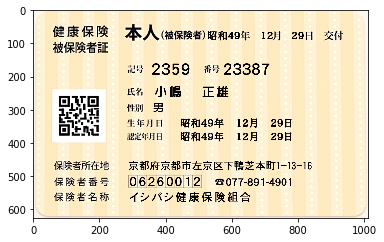

In [502]:
Display.display_img_nb(img)

In [522]:
bps = gcv_res_dict["01"]["bouding_poly"][1:]
bps

['[(61,40),(382,44),(381,92),(60,88)]',
 '[(387,45),(400,45),(399,92),(386,92)]',
 '[(401,45),(503,46),(502,93),(400,92)]',
 '[(511,46),(524,46),(523,93),(510,93)]',
 '[(529,46),(645,48),(644,96),(528,94)]',
 '[(695,49),(837,51),(836,98),(694,96)]',
 '[(881,51),(933,52),(932,100),(880,99)]',
 '[(65,92),(223,92),(223,132),(65,132)]',
 '[(295,150),(326,150),(326,208),(295,208)]',
 '[(360,150),(476,150),(476,208),(360,208)]',
 '[(517,150),(559,150),(559,208),(517,208)]',
 '[(582,150),(709,150),(709,208),(582,208)]',
 '[(290,221),(324,221),(324,269),(290,269)]',
 '[(368,221),(447,221),(447,269),(368,269)]',
 '[(510,221),(589,221),(589,269),(510,269)]',
 '[(290,276),(327,276),(327,310),(290,310)]',
 '[(370,276),(379,276),(379,310),(370,310)]',
 '[(281,321),(390,320),(390,356),(281,357)]',
 '[(450,320),(563,319),(563,355),(450,356)]',
 '[(617,319),(778,318),(778,353),(617,354)]',
 '[(293,365),(384,364),(384,396),(293,397)]',
 '[(451,364),(775,361),(775,393),(451,396)]',
 '[(157,353),(200,353

In [524]:
bps = BP.convert_to_array(bps)
bps

[array([[ 61.,  40.],
        [382.,  44.],
        [381.,  92.],
        [ 60.,  88.]], dtype=float32), array([[387.,  45.],
        [400.,  45.],
        [399.,  92.],
        [386.,  92.]], dtype=float32), array([[401.,  45.],
        [503.,  46.],
        [502.,  93.],
        [400.,  92.]], dtype=float32), array([[511.,  46.],
        [524.,  46.],
        [523.,  93.],
        [510.,  93.]], dtype=float32), array([[529.,  46.],
        [645.,  48.],
        [644.,  96.],
        [528.,  94.]], dtype=float32), array([[695.,  49.],
        [837.,  51.],
        [836.,  98.],
        [694.,  96.]], dtype=float32), array([[881.,  51.],
        [933.,  52.],
        [932., 100.],
        [880.,  99.]], dtype=float32), array([[ 65.,  92.],
        [223.,  92.],
        [223., 132.],
        [ 65., 132.]], dtype=float32), array([[295., 150.],
        [326., 150.],
        [326., 208.],
        [295., 208.]], dtype=float32), array([[360., 150.],
        [476., 150.],
        [476., 208.]

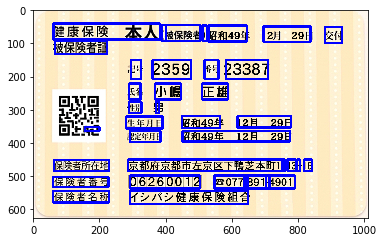

In [526]:
Display.draw_boxes(img, bps)

In [611]:
# find all word that are in the same line from block words
block_words = gcv_res_dict["01"]["final_text"]
element_words = gcv_res_dict["01"]["full_text"][1:]
element_words_bp = gcv_res_dict["01"]["bouding_poly"][1:]
# convert raw bp into array
element_words_bp = BP.convert_to_array(element_words_bp)

# find bp for block words
match_texts, match_bp = BP.find_block_words_bp(block_words, element_words, element_words_bp)
match_texts

/Users/thuyttt/Documents/AI-Lab/05_Programming/ocr-research/src/ocr_base/image_processing/bounding_poly.py:270: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  element_words_bp = [x for x in element_words_bp if x != ""]


['健康保険本人 ( 被保険者 ) 昭和49年 12月29日 交付',
 '被保険者証',
 '記号 2359 番号 23387',
 '氏名 小嶋 正雄',
 '性別 男',
 '生年月日 昭和49年 12月29日',
 '認定年月日 昭和49年12月29日',
 'に',
 '保険者所在地',
 '保険者番号',
 '保険者名称',
 '京都府京都市左京区下鴨芝本町1 - 13 - 16',
 '06260012 8077 - 891 - 4901',
 'イシバシ健康保険組合']

In [612]:
match_bp

[array([[ 61.,  40.],
        [933.,  44.],
        [932., 100.],
        [ 60.,  99.]], dtype=float32), array([[ 65.,  92.],
        [223.,  92.],
        [223., 132.],
        [ 65., 132.]], dtype=float32), array([[295., 150.],
        [709., 150.],
        [709., 208.],
        [295., 208.]], dtype=float32), array([[290., 221.],
        [589., 221.],
        [589., 269.],
        [290., 269.]], dtype=float32), array([[290., 276.],
        [379., 276.],
        [379., 310.],
        [290., 310.]], dtype=float32), array([[281., 319.],
        [778., 318.],
        [778., 356.],
        [281., 357.]], dtype=float32), array([[293., 364.],
        [775., 361.],
        [775., 396.],
        [293., 397.]], dtype=float32), array([[157., 353.],
        [200., 353.],
        [200., 365.],
        [157., 365.]], dtype=float32), array([[ 62., 452.],
        [229., 452.],
        [229., 484.],
        [ 62., 484.]], dtype=float32), array([[ 60., 502.],
        [227., 502.],
        [227., 534.]

(61.0, 40.0, 872.0, 59.0)
(65.0, 92.0, 158.0, 40.0)
(295.0, 150.0, 414.0, 58.0)
(290.0, 221.0, 299.0, 48.0)
(290.0, 276.0, 89.0, 34.0)
(281.0, 319.0, 497.0, 38.0)
(293.0, 364.0, 482.0, 33.0)
(157.0, 353.0, 43.0, 12.0)
(62.0, 452.0, 167.0, 32.0)
(60.0, 502.0, 167.0, 32.0)
(59.0, 546.0, 169.0, 34.0)
(287.0, 450.0, 555.0, 34.0)
(293.0, 498.0, 498.0, 40.0)
(292.0, 545.0, 357.0, 40.0)


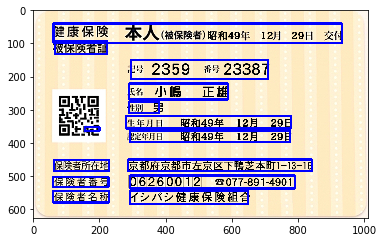

In [613]:
img = cv2.imread(img_path, 1)
Display.draw_boxes(img, match_bp)

In [614]:
# separate by distance
word_to_match = match_texts[0]
print(word_to_match)
word_vector = match_texts
bps = match_bp

健康保険本人 ( 被保険者 ) 昭和49年 12月29日 交付


In [615]:
BP.separate_by_distance(word_to_match, word_vector, bps)

[0]

In [616]:
# sep_texts = block_words.split("\n")
same_line_word_idx = []
for word in match_texts:
    tmp_same_line_word_idx = BP.separate_by_distance(word_to_match=word, word_vector=match_texts, bps=match_bp)
#     print("same_line_word_idx", tmp_same_line_word_idx)
    sorted_idx = sorted(tmp_same_line_word_idx)
#     print("sorted_idx", sorted_idx)
    if sorted_idx not in same_line_word_idx:
        same_line_word_idx.append(sorted_idx)
#         print("same_line_word_idx", same_line_word_idx)
print("same_line_word_idx", same_line_word_idx)

same_line_word_idx [[0], [1], [2], [3], [4], [5, 7], [6], [8, 11], [9, 12], [10, 13]]


In [617]:
same_line_texts = []
for idx in same_line_word_idx:
    tmp_idx = idx
    if len(tmp_idx) > 1:
        tmp_text = ""
        for value in tmp_idx:
            tmp_text = tmp_text + " " + sep_texts[value]
    else:
        tmp_text = sep_texts[tmp_idx[0]]
    same_line_texts.append(tmp_text)
same_line_texts

['健康保険本人(被保険者) 昭和49年 12月29日 交付',
 '被保険者証',
 '記号 2359 番号 23387',
 '氏名 小嶋 正雄',
 '性別 男',
 ' 生年月日 昭和49年 12月29日 に',
 '認定年月日 昭和49年12月29日',
 ' 保険者所在地 京都府京都市左京区下鴨芝本町1-13-16',
 ' 保険者番号 06260012 8077-891-4901',
 ' 保険者名称 イシバシ健康保険組合']